# Inverse design of perfectly vertical photonic (meta)grating coupler

## Geometry

running luminescent python frontend


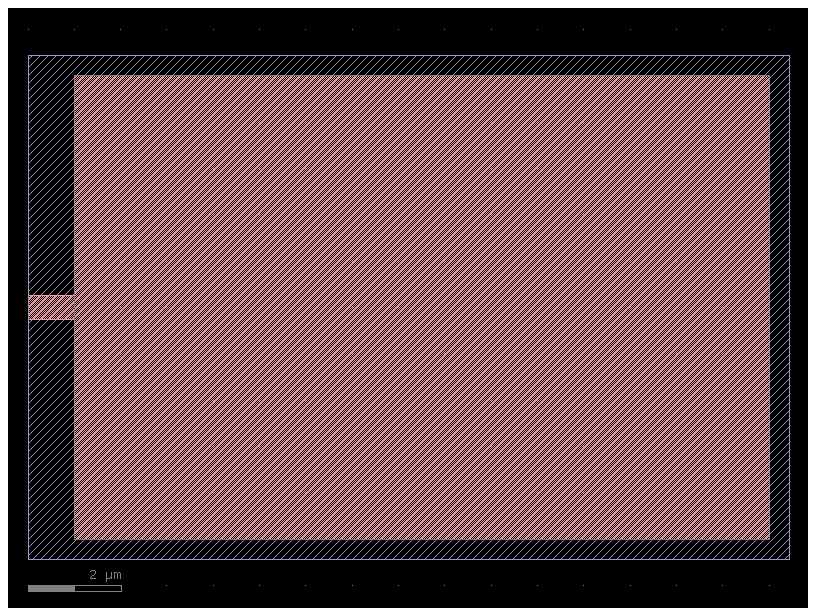

In [2]:
import math
import os
import matplotlib.pyplot as plt
import luminescent as lumi
import gdsfactory as gf
from gdsfactory.technology import LogicalLayer, LayerLevel, LayerStack
import numpy as np
from IPython.display import Image, display

path = os.path.join("studies", "metagrating_coupler")
wl = 1.55  # um
bw = 0.02
wavelengths = [wl - bw / 2, wl, wl + bw / 2]  # um

material_library = lumi.MATERIAL_LIBRARY
material_library["background"] = material_library["SiO2"]  # set background material
nSi = math.sqrt(material_library["Si"]["epsilon"])
nox = math.sqrt(material_library["SiO2"]["epsilon"])

w = 0.5  # gaussian beam waist
R = 1.0 * w  # source radius
width = 10  # of design region
length = 1.5 * width  # of design region
w_wg = 0.5
l_wg = 2 * w_wg
dz = 0.1

# margins
lateral_port_margin = height_port_margin = 0.3
xmargin = 1.5 * lateral_port_margin
zmargin = 1.5 * height_port_margin
box_thickness = 0.5
source_port_margin = 1.5 * dz

WG = 1, 0
TEETH = 2, 0
BBOX = 4, 0
DESIGN = 100, 0

# makes gdsfadory component to be optimized. has rectangular design region with port stubs. ports numbered clockwise from bottom left.
c = gf.Component()
dut = c << lumi.mimo(
    length,
    width,
    w_wg=w_wg,
    l_wg=l_wg,
    west=1,
    layer_wg=WG,
    layer_design=DESIGN,
    init=1,
)

xoffset = -(length - width + width / 2)
yoffset = -(width / 2)
dut.movex(xoffset)
dut.movey(yoffset)
c.add_port("o2", port=dut.ports["o1"])

c << gf.components.bbox(
    component=c, layer=BBOX, top=xmargin, bottom=xmargin, right=xmargin
)
c.plot()


## Solve

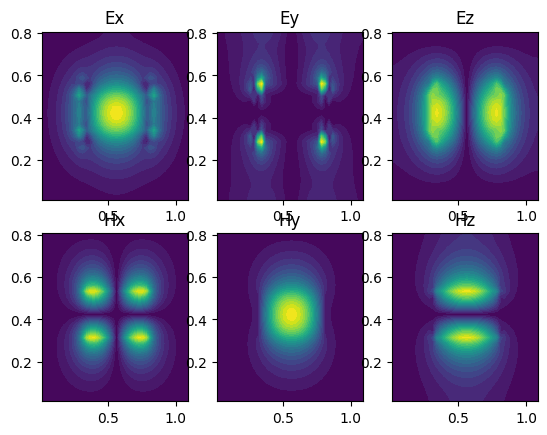

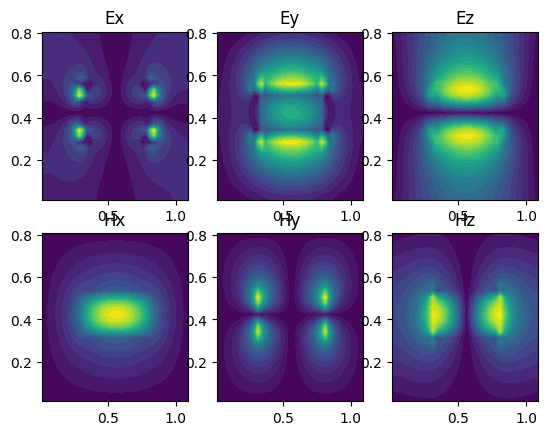

using simulation folder c:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\studies\metagrating_coupler


c:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\luminescent\sparams.py:127: UserWarning: Layer (200, 0) not found in component 'Unnamed_20' layers. [(1, 0), (4, 0), (100, 0)]
  bbox = component.extract([layer]).bbox_np().tolist()


0

In [ ]:
# layer stack. lower mesh order layers override higher mesh order layers. for 2.5D problems as is here, the mesher will slice thru middle of 'core' layer
thickness_teeth = 0.07
thickness_slab = 0.15
thickness = thickness_teeth + thickness_slab
layer_stack = LayerStack(
    layers={
        "design": LayerLevel(
            layer=LogicalLayer(layer=DESIGN),
            zmin=thickness_slab,
            thickness=thickness_teeth,
            material="design",
            mesh_order=0,
        ),
        "teeth": LayerLevel(
            layer=LogicalLayer(layer=TEETH),
            zmin=thickness_slab,
            thickness=thickness_teeth,
            material="Si",
            mesh_order=1,
        ),
        "core": LayerLevel(
            layer=LogicalLayer(layer=WG),
            zmin=0,
            thickness=thickness,
            material="Si",
            mesh_order=3,
        ),
    }
)

# make fiber mode
nx = 2 * round(R / 0.05)
_dx = 2 * R / nx
x = np.linspace(-R + _dx / 2, R - _dx / 2, nx)
y = np.linspace(-R + _dx / 2, R - _dx / 2, nx)
X, Y = np.meshgrid(x, y)
g = np.exp(-(X**2 + Y**2) / (2 * w**2))

modes = [
    lumi.Mode(ports=["o1"], fields={"Ey": g, "Hx": -nox * g}, dx=_dx),
    lumi.Mode(ports=["o2"]),
]

# additional ports not attached to gdsfactory component
ports = [
    lumi.PlanePort(
        name="o1",
        origin=[0, 0, thickness + dz],
        frame=[[1, 0, 0], [0, 1, 0], [0, 0, 1]],
        length=2 * R,
        width=2 * R,
    )
]

sources = [
    lumi.Source(
        "o1",
        source_port_margin=source_port_margin,
    )
]

# optimization targets of T params. o1@0 means optical port 1 on mode 0 (fundamental mode)
targets = [
    lumi.Target("To2@0,o1@0", 1.0, weight=1 / len(wavelengths), wavelength=x)
    for x in wavelengths
]

tmax = (
    1.0
    * (length + width / 2 + 2 * box_thickness + zmargin + 2 * thickness + l_wg)
    / wl
    * nSi
    + 5
)  # max time [periods]

designs = [
    lumi.Design(
        "d1",
        layer=DESIGN,
        lmin=0.2,
        fill_material="Si",
        void_material="SiO2",
        symmetries=["y"],
        uniform_along="z",
    )
]
optimizer = lumi.Optimizer(
    stoploss=0.2,
    area_change=0.03,  # area change initial target
    iters=20,  # max iters
)

lumi.make(
    #
    path=path,  # path to make problem folder
    component=c,
    wavelengths=wavelengths,
    ports=ports,
    modes=modes,
    sources=sources,
    boundaries=["PML", "PML", ["PEC", "PML"]],
    #
    material_library=material_library,
    layer_stack=layer_stack,
    #
    lateral_port_margin=lateral_port_margin,
    height_port_margin=height_port_margin,
    zmin=-box_thickness,  # zmin of simulation region
    zmax=thickness + zmargin,  # zmax of simulation region
    #
    gpu="CUDA",
    relative_courant=0.9,
    nres=4,  # number of grid points per wavelength in material (not vacuum)
    tmax=tmax,  # total simulation time in periods
    relative_pml_depths=[[1, 0.3], 0.3, 1],  # relative PML thicknesses in x, y, z
    #
    saveat=10,  # save frame every `saveat` periods for movie
    force=True,  # delete and overwrite existing path
    #
    show_field="Ey",
    show_grid=False,
    field_slices=[0, 0, thickness_teeth / 2 + thickness_slab],
    geometry_slices=[0, 0, thickness_teeth / 2 + thickness_slab],
    # inverse design parameters
    targets=targets,
    designs=designs,
    optimizer=optimizer,
)
# studies adjoint optimization.
lumi.solve(path)
display(Image(filename=os.path.join(path, "peak.gif")))

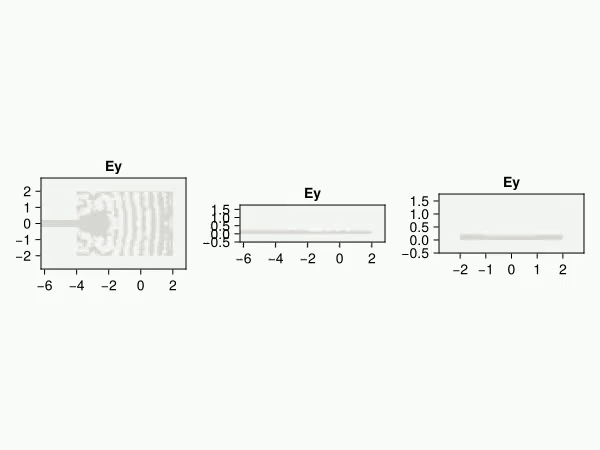